In [87]:
%load_ext autoreload
%autoreload 2
%load SA_PT.py

#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @Time    : 2022/10/08 13:58
# @Author  : Wang Yujia
# @File    : PT_demo.ipynb

# @Description : 1. 主要是复现一下table 1的结果 2. SA的内容在SA_for_PT_model.ipynb上

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Preparations
## 1.1 全局设置

In [80]:
# auction setting
b = 2
V = 6
d = 1

T = 3

import numpy as np
import pandas as pd
import sympy
# from sko.SA import SA
from scipy import optimize
from tqdm.notebook import tqdm
import seaborn as sns

# 2. 验证Table.1
## 2.1 With EUT

In [ ]:
print("With EUT\n")
x_1 = sympy.Symbol('x_1')
def func(x):
    return x * (-b) + (1 - x) * (V - t * d - b)

p=[]
for t in range(1,T+1):
    p.append(float((sympy.nsolve(func,x_1,(0,1)))))
    print("p[{0}]: {1}".format(t,p[t-1]))

## 2.2 With PT
1. 为了验证Table 1但是failed，只有最后一组[1,1,2.25]的第一个结果对不上
2. 侧面说明`C=[0,0,0,b]`是正确的设置？

In [104]:
# prob. weighting function
def omg(p):
    tmp = p**delta
    return tmp*((tmp + (1-p)**delta)**(-1/delta))

# value function
def f_x(x):
    return x**alpha

# for PT
alpha = 1
delta = 1
labda = 2.25

print("With PT\n")
x = sympy.Symbol('x')
p_2=[]
C=[0,0,0,b]
for t in range(1,T+1):
        #C = (t-1)*b*0.2
        tmp = V-d*(t)-C[t]-b
        if(tmp > 0):
            print(">0")
            func_1 = (labda*f_x(C[t]) + omg(x)*(-labda)*f_x(C[t]+b) + omg(1-x)*f_x(tmp))
            p_2.append((sympy.nsolve(func_1,(0,1), solver='bisect', verify=False)))
        else:
            print("<=0")
            func_2 = (-f_x(C[t]) + omg(x)*(f_x(C[t]+b))+(1-omg(x))*f_x(-tmp))
            p_2.append((sympy.nsolve(func_2, (0,1), solver='bisect', verify=False)))
        print("p[{0}]: {1}".format(t,p_2[t-1]))

With PT

>0
p[1]: 0.400000000000000
>0
p[2]: 0.307692307692308
<=0
p[3]: 0.333333333333333


# 3. PA test
1. 目的是求一个uniq auction下的u，观察过程与debug
## 3.1 preparations
1. v b d max_T都来自真实值

In [24]:
# auction setting from Swoopo
#b = 0.75
#v = 169.99
#d = 0.15

# auction setting from paper Fig.1 left
b= 0.75
v = 27.99
d = 0.01

# from Table 5 'All auction'
alpha = 0.025
delta = 0.85
labda = 3.72

# max duration
max_T = 831
T = int((v-b)/d)

## 3.2 function definition
1. 根据Eq(7)-(9)

In [4]:
def C(t,b):
    return 0.2*t*b

def OMEGA(p,delta):
    return p**delta * ((p**delta + (1-p)**delta)**(-1/delta))

# valuation function
def f(x, alpha):
    return (1-sympy.E**(-alpha*x))/alpha
    # when x < 0, in fact, it shoule be : (-labda)*(1-sympy.E**(alpha*x))/alpha

def f_Equi(t,v,d,b,alpha,labda,delta):
    u = sympy.Symbol('u')

    tmp = v-d*t-C(t-1,b) - b

    func_1 = (labda * f(x=C(t-1, b), alpha=alpha) - labda * OMEGA(u, delta) * f(x=(C(t-1, b) + b), alpha=alpha) + OMEGA(1-u, delta) * f(tmp, alpha))
    func_2 = (-f(x=C(t-1, b), alpha=alpha) + OMEGA(u, delta) * f(x=(C(t-1, b) + b), alpha=alpha) + (1 - OMEGA(u, delta)) * f(-tmp, alpha))

    if(tmp >= 0):
        return sympy.nsolve(func_1,(0,1),solver='bisect', verify=False)
    else:
        return sympy.nsolve(func_2,(0,1),solver='bisect', verify=False)

## 3.3 implement and plot
1. 计算u和p，并且画图p

In [47]:
# solve for u from Equi. condt.
U_tmp = [0]*(T+1)
U_tmp[0] = 1
# P is what we want
P_tmp = [0]*(T+1)
P_tmp[0] = 1

tmp = 1
for t in tqdm(range(1,T+1),desc="solve for u"):

    if((t>1) & (U_tmp[t-1] > 1-1e-5)):
        print("Break when t == {}, cause U_tmp[t-1] > 1-1e-6".format(t))
        break
    U_tmp[t] = f_Equi(t,v,d,b,alpha,labda,delta)
    P_tmp[t] = (1- U_tmp[t])*tmp
    tmp = tmp*U_tmp[t]

solve for u:   0%|          | 0/2724 [00:00<?, ?it/s]

# 4. SA
## 4.1 SA trial
1. `SA`来自`SA_PT.py`
2.

10 

best_x: [-8.69748680e-06  5.00005826e-02 -2.31714330e-06] best_y 8.135487949288827e-11
8.135487949288827e-11
True


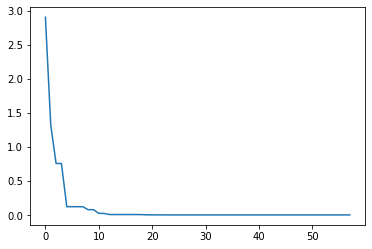

In [93]:
from SA_PT import SA
demo_func = lambda x: x[0] ** 2 + (x[1] - 0.05) ** 2 + x[2] ** 2

sa = SA(func=demo_func, x0=[1, 1, 1], T_max=1, T_min=1e-9, L=300, max_stay_counter=150)
best_x, best_y = sa.run()
print('best_x:', best_x, 'best_y', best_y)
print(best_x[0] ** 2 + (best_x[1] - 0.05) ** 2 + best_x[2] ** 2)

sns.lineplot(x = np.arange(0,sa.iter_cycle+1),y=np.array(sa.generation_best_Y))
print(sa.generation_best_Y == sa.best_y_history)

<AxesSubplot:xlabel='x', ylabel='y'>

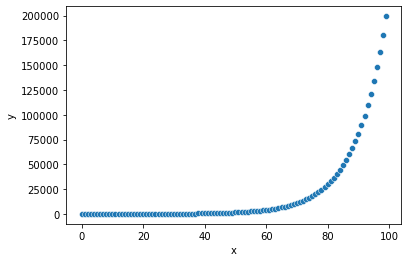

In [157]:
alpha = -0.1
def g(x):
    return (1-np.exp(-alpha*x))/alpha

x_g = pd.DataFrame(np.arange(0,100),index=(np.arange(0,100)),columns=['x'])
x_g['y'] = x_g.apply(g,axis=1)
sns.scatterplot(x = x_g['x'],y=x_g['y'])